# INDIAN SIGN LANGUAGE RECOGNITION

Indian Sign Language(ISL) forms the most widely accepted communication method used by the deaf and mute communities of India. The vocabulary of ISL is formed by various hand gestures, facial expressions and certain body movements. The fact being that India is home to more than 12 million deaf people, a way to lessen the communication gap between the deaf community and ordinary people is essential.
 
That said, we need a model that could overcome many difficulties posed by the recognition process. But technically speaking, no public dataset, little distortion from signer to signer, size of hands, color of skin, noise in background everything poses a difficulty while training a model. Furthermore, to make an effective model, data that encapsulates all these changes must be formed from scratch.
 
Although there are several problems those hinder the project, the solution to the problem has been tried by many researchers, both in the field of computer vision and machine learning. And I wish to contribute to the cause myself using the knowledge I have gained through this nanodegree.


In [1]:
from PIL import Image
import numpy as np
import cv2
from sklearn import tree
import pandas as pd
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

In [2]:
traindata=pd.read_csv('traindata.csv')
traindata=traindata.drop(['Unnamed: 0'],axis=1)
labeldata=pd.read_csv('labeldata.csv')
labeldata=labeldata.drop(['Unnamed: 0'],axis=1)

In [3]:
print("There are {} images in the dataset".format(traindata.shape[0]))
print("There are {} classes for the dataset".format(labeldata.shape[1]))

There are 9765 images in the dataset
There are 15 classes for the dataset


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(traindata,labeldata, test_size=0.1024, random_state=100)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

print("There are {} images in the training dataset".format(X_train.shape[0]))
print("There are {} images in the testing dataset".format(X_test.shape[0]))

(8765, 3072)
(8765, 15)
(1000, 3072)
(1000, 15)
There are 8765 images in the training dataset
There are 1000 images in the testing dataset


To give the idea of how the captured images after skin detection and largest contour detection looks, lets see some random images.

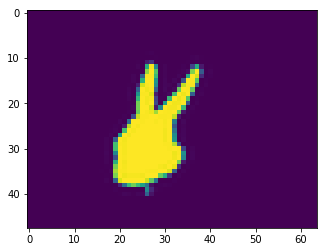

In [77]:
#change the image_number and you can plot any image that you want to visualize

image_number = 4200
import matplotlib.pyplot as plt
img1 = traindata[image_number:image_number+1]
img1 = img1.values.reshape(48,64)
plt.imshow(img1)
plt.show()

In [5]:
#Since my laptop doesn't have much RAM, I have divided the training dataset into 5 batches

print("There are {} images in each batch".format(int(len(X_train)/5)))

There are 1753 images in each batch


In [6]:
#manually splitting each batch into 1750 images each


len_X_train = int(len(X_train)/5)-3

X_train_1 = X_train[:len_X_train]
Y_train_1 = Y_train[:len_X_train]

X_train_2 = X_train[len_X_train : len_X_train*2]
Y_train_2 = Y_train[len_X_train : len_X_train*2]

X_train_3 = X_train[len_X_train*2 : len_X_train*3]
Y_train_3 = Y_train[len_X_train*2 : len_X_train*3]

X_train_4 = X_train[len_X_train*3 : len_X_train*4]
Y_train_4 = Y_train[len_X_train*3 : len_X_train*4]

X_train_5 = X_train[len_X_train*4 :]
Y_train_5 = Y_train[len_X_train*4 :]


#modifying the data to fit into the CNN

X_train_1=X_train_1.as_matrix()
Y_train_1=Y_train_1.as_matrix()

X_train_2=X_train_2.as_matrix()
Y_train_2=Y_train_2.as_matrix()

X_train_3=X_train_3.as_matrix()
Y_train_3=Y_train_3.as_matrix()

X_train_4=X_train_4.as_matrix()
Y_train_4=Y_train_4.as_matrix()

X_train_5=X_train_5.as_matrix()
Y_train_5=Y_train_5.as_matrix()

X_test=X_test.as_matrix()
Y_test=Y_test.as_matrix()

X_train_1=X_train_1.reshape(1750,64,48,1)
X_train_2=X_train_2.reshape(1750,64,48,1)
X_train_3=X_train_3.reshape(1750,64,48,1)
X_train_4=X_train_4.reshape(1750,64,48,1)
X_train_5=X_train_5.reshape(1765,64,48,1)
X_test=X_test.reshape(1000,64,48,1)


#this function returns a training batch.
#it takes in paramater batch_number and returns the same batch

def X_batch(batch_number) :
    if batch_number == 1 :
        return X_train_1
    if batch_number == 2 :
        return X_train_2
    if batch_number == 3 :
        return X_train_3
    if batch_number == 4 :
        return X_train_4
    if batch_number == 5 :
        return X_train_5

    
#same as the previous funtion except that it returns the labels for the data batches.
    
def Y_batch(batch_number) :
    if batch_number == 1 :
        return Y_train_1
    if batch_number == 2 :
        return Y_train_2
    if batch_number == 3 :
        return Y_train_3
    if batch_number == 4 :
        return Y_train_4
    if batch_number == 5 :
        return Y_train_5    

To obtain the perfect results, we need confusion metrics but the problem with confusion metrics in sklearn is that it takes in input two 1D arrays but our labels for CNN are of shape (n,15) since there are 15 classes. To deal with this problem, we should matrix multiply the labels of shape (n,15) to a matrix to return us a 1D array. The code for same is in the session of tensorflow. The matrix we should multiply the labels with is declared below

In [13]:
from sklearn.metrics import confusion_matrix
multiplier_matrix = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

The CNN that I will be using will have 2 convolutional layers and a fully connected layer that shall further join to the output layer. I have used maxpooling for the CNN and used a dropout of 80% to prevent overfitting. All the required weights, biases and different functions of the CNN are declared in the next cell

In [16]:
learning_rate = 0.0001
epochs = 100
n_classes = 15 
dropout = 0.80

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32],mean=0.0,stddev=1.0),name='wc1'),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64],mean=0.0,stddev=1.0),name='wc2'),
    'wd1': tf.Variable(tf.random_normal([16*12*64, 1024],mean=0.0,stddev=1.0),name='wd1'),
    'w_out': tf.Variable(tf.random_normal([1024, n_classes],mean=0.0,stddev=1.0),name='w_out')}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]),name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]),name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]),name='bd1'),
    'b_out': tf.Variable(tf.random_normal([n_classes]),name='b_out')}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    # Layer 1 - 64*48*1 to 32*24*32
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 32*24*32 to 16*12*64
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    
    # Fully connected layer - 16*12*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 5
    out = tf.add(tf.matmul(fc1, weights['w_out']), biases['b_out'])
    return out

# tf Graph input
x = tf.placeholder(tf.float32, [None,64,48,1])
y = tf.placeholder(tf.float32, [None,n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model--output for each image
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

saver = tf.train.Saver()
# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    
    from sklearn.metrics import confusion_matrix
    multiplier_matrix = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    
    for epoch in range(epochs):
        
        for i in [1,2,3,4,5] :
            batch_x = X_batch(i)
            batch_y = Y_batch(i)
        
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            print('Epoch : {:>2} --batch : {} --- Loss : {:>10.4f}'.format(epoch + 1,i,loss))
        
        test_acc = sess.run(accuracy, feed_dict={
          x:X_test,
          y:Y_test,
          keep_prob: 1.0})

        print('Testing Accuracy after epoch {} : {}'.format(epoch,test_acc))
        
        if (epoch+1 % 10 == 0) or (epoch == 0) or (epoch == 99) :
            y_true_labels = np.matmul(Y_test,multiplier_matrix)
            y_p = tf.argmax(logits, 1)
            val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:X_test,y:Y_test,keep_prob: 1.0})
            #print(confusion_matrix(y_true_labels, y_pred))

            y_actu = pd.Series(y_true_labels, name='Actual')
            y_pred = pd.Series(y_pred, name='Predicted')
            df_confusion = pd.crosstab(y_actu, y_pred)
            #print(df_confusion)    

            df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
            print(df_confusion)

            #df_conf_norm = df_confusion / df_confusion.sum(axis=1)
            #print(df_conf_norm)
            

    weights_updated = {
        'wc1_updated': tf.Variable(weights['wc1'],name='wc1_updated'),
        'wc2_updated': tf.Variable(weights['wc2'],name='wc2_updated'),
        'wd1_updated': tf.Variable(weights['wd1'],name='wd1_updated'),
        'w_out_updated': tf.Variable(weights['w_out'],name='w_out_updated')}

    biases_updated = {
        'bc1_updated': tf.Variable(biases['bc1'],name='bc1_updated'),
        'bc2_updated': tf.Variable(biases['bc2'],name='bc2_updated'),
        'bd1_updated': tf.Variable(biases['bd1'],name='bd1_updated'),
        'b_out_updated': tf.Variable(biases['b_out'],name='b_out_updated')}
    
    """
    y_true_labels = np.matmul(Y_test,multiplier_matrix)
    y_p = tf.argmax(logits, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:X_test,y:Y_test,keep_prob: 1.0})
    #print(y_pred.shape,y_true_labels.shape)
    #y_pred = np.matmul(y_pred,multiplier_matrix)
    print(confusion_matrix(y_true_labels, y_pred))
    """
    
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, "model/final_static_model")
    print("Model saved in file: %s" % save_path)

Epoch :  1 --batch : 1 --- Loss : 114282.5781
Epoch :  1 --batch : 2 --- Loss : 77334.7578
Epoch :  1 --batch : 3 --- Loss : 43883.4844
Epoch :  1 --batch : 4 --- Loss : 41293.7539
Epoch :  1 --batch : 5 --- Loss : 18561.9746
Testing Accuracy after epoch 0 : 0.3370000123977661
Predicted   0    1   3  4    5    6   7   8  9   11  12   13   All
Actual                                                            
0          44    0   0  0    0   26   0   0  0    0   0    0    70
1           0   67   0  0    0    0   0   0  0    0   0    1    68
2           2    3   0  0   16    0   1   0  0   14   0   27    63
3           0    0   3  0   44   10   2   1  0    0   1    0    61
4           1    9   0  1    0    0   0   0  0    0   0   50    61
5           0    0   0  0   49    8   0   0  0    0   0    0    57
6           0    0   0  0    5   57   0   0  0    0   0    0    62
7           2    1   0  0    9   24   9   0  0   12   0    6    63
8           0   11   0  0    4    8   2   1  0    3 

Epoch : 26 --batch : 3 --- Loss :    69.4712
Epoch : 26 --batch : 4 --- Loss :    42.2192
Epoch : 26 --batch : 5 --- Loss :    48.2713
Testing Accuracy after epoch 25 : 0.9879999756813049
Epoch : 27 --batch : 1 --- Loss :    46.4539
Epoch : 27 --batch : 2 --- Loss :    33.2424
Epoch : 27 --batch : 3 --- Loss :    73.9766
Epoch : 27 --batch : 4 --- Loss :    41.4011
Epoch : 27 --batch : 5 --- Loss :    46.4777
Testing Accuracy after epoch 26 : 0.9890000224113464
Epoch : 28 --batch : 1 --- Loss :    44.6374
Epoch : 28 --batch : 2 --- Loss :    28.7090
Epoch : 28 --batch : 3 --- Loss :    76.2431
Epoch : 28 --batch : 4 --- Loss :    40.9669
Epoch : 28 --batch : 5 --- Loss :    46.1214
Testing Accuracy after epoch 27 : 0.9900000095367432
Epoch : 29 --batch : 1 --- Loss :    39.5668
Epoch : 29 --batch : 2 --- Loss :    30.9898
Epoch : 29 --batch : 3 --- Loss :    67.3691
Epoch : 29 --batch : 4 --- Loss :    38.8827
Epoch : 29 --batch : 5 --- Loss :    43.6868
Testing Accuracy after epoch 28

Testing Accuracy after epoch 54 : 0.9959999918937683
Epoch : 56 --batch : 1 --- Loss :    16.0668
Epoch : 56 --batch : 2 --- Loss :     5.3269
Epoch : 56 --batch : 3 --- Loss :    16.2239
Epoch : 56 --batch : 4 --- Loss :    13.8942
Epoch : 56 --batch : 5 --- Loss :    16.3904
Testing Accuracy after epoch 55 : 0.9950000047683716
Epoch : 57 --batch : 1 --- Loss :    15.2442
Epoch : 57 --batch : 2 --- Loss :     4.1328
Epoch : 57 --batch : 3 --- Loss :    13.8452
Epoch : 57 --batch : 4 --- Loss :    12.6987
Epoch : 57 --batch : 5 --- Loss :    16.1712
Testing Accuracy after epoch 56 : 0.9959999918937683
Epoch : 58 --batch : 1 --- Loss :    14.6752
Epoch : 58 --batch : 2 --- Loss :     4.5340
Epoch : 58 --batch : 3 --- Loss :    13.8993
Epoch : 58 --batch : 4 --- Loss :    12.2961
Epoch : 58 --batch : 5 --- Loss :    15.4654
Testing Accuracy after epoch 57 : 0.9959999918937683
Epoch : 59 --batch : 1 --- Loss :    12.6953
Epoch : 59 --batch : 2 --- Loss :     5.2429
Epoch : 59 --batch : 3 

Epoch : 85 --batch : 3 --- Loss :     5.0813
Epoch : 85 --batch : 4 --- Loss :     6.1763
Epoch : 85 --batch : 5 --- Loss :     7.8791
Testing Accuracy after epoch 84 : 0.9959999918937683
Epoch : 86 --batch : 1 --- Loss :     4.9401
Epoch : 86 --batch : 2 --- Loss :     1.4456
Epoch : 86 --batch : 3 --- Loss :     4.4827
Epoch : 86 --batch : 4 --- Loss :     5.7370
Epoch : 86 --batch : 5 --- Loss :     8.1539
Testing Accuracy after epoch 85 : 0.996999979019165
Epoch : 87 --batch : 1 --- Loss :     6.0223
Epoch : 87 --batch : 2 --- Loss :     0.3891
Epoch : 87 --batch : 3 --- Loss :     2.9854
Epoch : 87 --batch : 4 --- Loss :     4.9096
Epoch : 87 --batch : 5 --- Loss :     7.6266
Testing Accuracy after epoch 86 : 0.996999979019165
Epoch : 88 --batch : 1 --- Loss :     4.8702
Epoch : 88 --batch : 2 --- Loss :     1.2914
Epoch : 88 --batch : 3 --- Loss :     3.3502
Epoch : 88 --batch : 4 --- Loss :     5.4481
Epoch : 88 --batch : 5 --- Loss :     6.6934
Testing Accuracy after epoch 87 :

For the benchmark model, I proposed to use decision tree classifier because unlike CNN, which are black box models, we can reason why a particular output was observed for the decision tree classifier. Moreover, since we have used decision tree classifier for skin detection, a question may arrise that why was decision tree classifier not used here as well instead of CNN those are very time consuming.

In [17]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(traindata,labeldata, test_size=0.1024, random_state=100)

print("There are {} images in the training dataset".format(X_train.shape[0]))
print("There are {} images in the testing dataset".format(X_test.shape[0]))

Y_train_labels = np.matmul(Y_train,multiplier_matrix)
Y_test_labels = np.matmul(Y_test,multiplier_matrix)

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, Y_train_labels)
#print(clf.feature_importances_)
print("Accuracy on testing data : {}".format(clf.score(X_test, Y_test_labels)))

y_pred = clf.predict(X_test)

y_actu = pd.Series(Y_test_labels, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

C:\Users\Shubam Sachdeva\AppData\Local\Continuum\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


There are 8765 images in the training dataset
There are 1000 images in the testing dataset
Accuracy on testing data : 0.993
Predicted  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
Actual                                                               
0          70   0   0   0   0   0   0   0   0   0   0   0   0   0   0
1           0  67   0   0   0   0   0   0   0   0   0   1   0   0   0
2           0   0  62   0   0   0   0   0   0   1   0   0   0   0   0
3           0   0   0  61   0   0   0   0   0   0   0   0   0   0   0
4           0   0   0   0  61   0   0   0   0   0   0   0   0   0   0
5           0   0   0   0   0  57   0   0   0   0   0   0   0   0   0
6           0   0   0   0   0   0  62   0   0   0   0   0   0   0   0
7           0   0   0   0   0   0   0  63   0   0   0   0   0   0   0
8           0   0   0   0   0   0   0   0  57   2   0   0   0   0   0
9           0   0   0   0   0   0   0   0   0  79   0   0   0   0   0
10          0   0   0   0   0   0   

As clearly seen in the two confusion metrics formed, the CNN model performs better. The performance of decision tree is also very good because the data prerocessing step is very vital and improves the preformance vastly. Moreover, the enormous data available makes the accuracy better and generalizes the model better. Although the perfromace of decision tree is very good but CNN is even better. Therefore, we have successfully made an improved model. Even better than suggested in most research papers.

For CNN, as the comfusion metrics suggests, there are only 3 images those are predicted wrong out of the 1000 testing images while for decision tree the wrong predictions are 7, more than double

In [73]:
#calculating precision and recall for both the classifiers :

from sklearn.metrics import recall_score,f1_score,precision_score
actual_label = [1]*1000

CNN_predicted_label = actual_label[:997]
for i in range(0,3) :
    CNN_predicted_label.append(2)
    
DT_predicted_label = actual_label[:993]

for i in range(0,7) :
    DT_predicted_label.append(2)

print("\nFor CNN :")
print(accuracy_score(CNN_predicted_label,actual_label))
print(recall_score(CNN_predicted_label,actual_label))
print(precision_score(CNN_predicted_label,actual_label))
print(f1_score(CNN_predicted_label,actual_label))

print("\nFor Decision Tree :")
print(accuracy_score(DT_predicted_label,actual_label))
print(recall_score(DT_predicted_label,actual_label))
print(precision_score(DT_predicted_label,actual_label))
print(f1_score(DT_predicted_label,actual_label))

1000
1000
1000
1003
1000
1007

For CNN :
0.997
1.0
0.997
0.99849774662

For Decision Tree :
0.993
1.0
0.993
0.996487706974


It is clear that f1 score that is considered most important for any classifier, because it captures both precision and recall, is also better for CNN. Hence we can safely state that form a 3 channel RGB  we have succesfully make very good data and further otu model works very well with the data made. CNN is the main classifier used in the project but the magical part for the project that enables such high accuracy and f1_score are the preprocessing steps taken for data making. Skin detection and largest contour detection simply eliminates all the possible reasons the accuracy would decrease.